In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import os.path as osp

import matplotlib.pyplot as plt

from vgg import vgg16_bn
from resnetbig import resnetdisentanglerbig

In [2]:
# load the CUB dataset
DATA_ROOT = "../data/CUB/CUB_strong"
CUB_mean = [0.485, 0.456, 0.406]
CUB_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CUB_mean, CUB_std)
])
transform_original = transforms.Compose([
    transforms.ToTensor()
])
train_set = datasets.ImageFolder(osp.join(DATA_ROOT, "train"), transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False)
train_set_original = datasets.ImageFolder(osp.join(DATA_ROOT, "train"), transform=transform_original)
train_loader_original = torch.utils.data.DataLoader(train_set_original, batch_size=1, shuffle=False)
test_set = datasets.ImageFolder(osp.join(DATA_ROOT, "test"), transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [3]:
# select the GPU
GPU_ID = 0

In [4]:
# load the target DNN. We disentangled the feature map after conv_43 in VGG16 into different complexity orders.
pretrained_model = vgg16_bn(pretrained=True).to(GPU_ID)
pretrained_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [5]:
def get_target(image):
    image = image.to(GPU_ID)
    f_target = pretrained_model.extract_feature(image, 4).detach().squeeze()
    max_idx = (f_target > 0).sum(dim=(1, 2)).argmax().item()
    f_target = f_target[max_idx].cpu().numpy()
    return f_target

In [6]:
def get_result(image, current_block, previous_block):
    current = resnetdisentanglerbig(current_block).to(GPU_ID)
    current.load_state_dict(torch.load(f"./models/{current_block}_steplr.pth"))
    current.eval()
    if current_block != 1:
        previous = resnetdisentanglerbig(previous_block).to(GPU_ID)
        previous.load_state_dict(torch.load(f"./models/{previous_block}_steplr.pth"))
        previous.eval()
    image = image.to(GPU_ID)
    f_current = current(image).detach().squeeze()
    f_target = pretrained_model.extract_feature(image, 4).detach().squeeze()
    if current_block != 1:
        f_previous = previous(image).detach().squeeze()
        f_new = f_current - f_previous
    else:
        f_new = f_current
    f_remain = f_target - f_current
    # TODO: visualize image, f_target, f_current, f_new, f_remain
    max_idx = (f_target > 0).sum(dim=(1, 2)).argmax().item()
    f_target = f_target[max_idx].cpu().numpy()
    f_current = f_current[max_idx].cpu().numpy()
    f_new = f_new[max_idx].cpu().numpy()
    f_remain = f_remain[max_idx].cpu().numpy()
    return f_current, f_new, f_remain

In [7]:
def get_visualization(img_idx):
    block_list = [1, 2, 4, 8, 16, 32]
    image = train_loader.dataset[img_idx][0]
    image = image.unsqueeze(0).to(GPU_ID)
    image_original = train_loader_original.dataset[img_idx][0].to(GPU_ID)
    image_original = image_original.squeeze().cpu().numpy().transpose(1, 2, 0)
    target = get_target(image)
    plt.figure(figsize=(16, 12))
    plt.subplot(4, 6, 1)
    plt.imshow(image_original)
    plt.title(r"Input image $x$")
    plt.subplot(4, 6, 2)
    plt.imshow(target, cmap="seismic", vmin=-1, vmax=1)
    plt.title(r"Target feature $f(x)$")

    for i in range(len(block_list)):
        current_block = block_list[i]
        previous_block = block_list[i-1]
        f_current, f_new, f_remain = get_result(image, current_block, previous_block)
        plt.subplot(4, 6, i + 7)
        plt.imshow(f_new, cmap="seismic", vmin=-1, vmax=1)
        plt.title(r"$c^{(%d)}(x)$"%(current_block*3+1))
        plt.subplot(4, 6, i + 13)
        plt.imshow(f_current, cmap="seismic", vmin=-1, vmax=1)
        plt.title(r"$\Phi^{(%d)}(x)$" % (current_block * 3 + 1))
        plt.subplot(4, 6, i + 19)
        plt.imshow(f_remain, cmap="seismic", vmin=-1, vmax=1)
        plt.title(r"$\Delta f, l=%d$"% (current_block * 3 + 1))
    plt.show()

In [8]:
%matplotlib inline

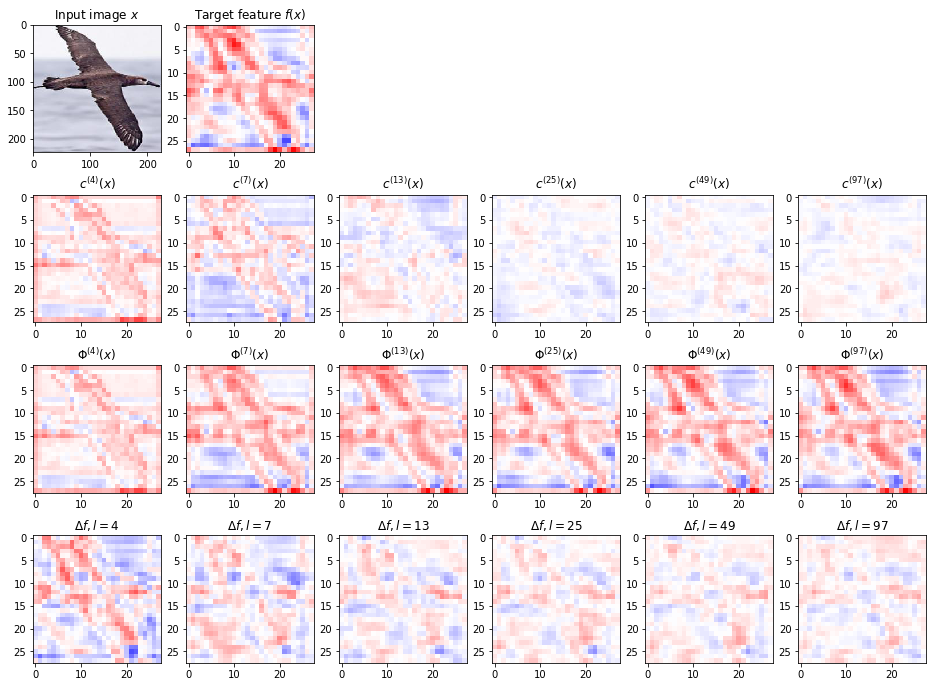

In [9]:
get_visualization(1)

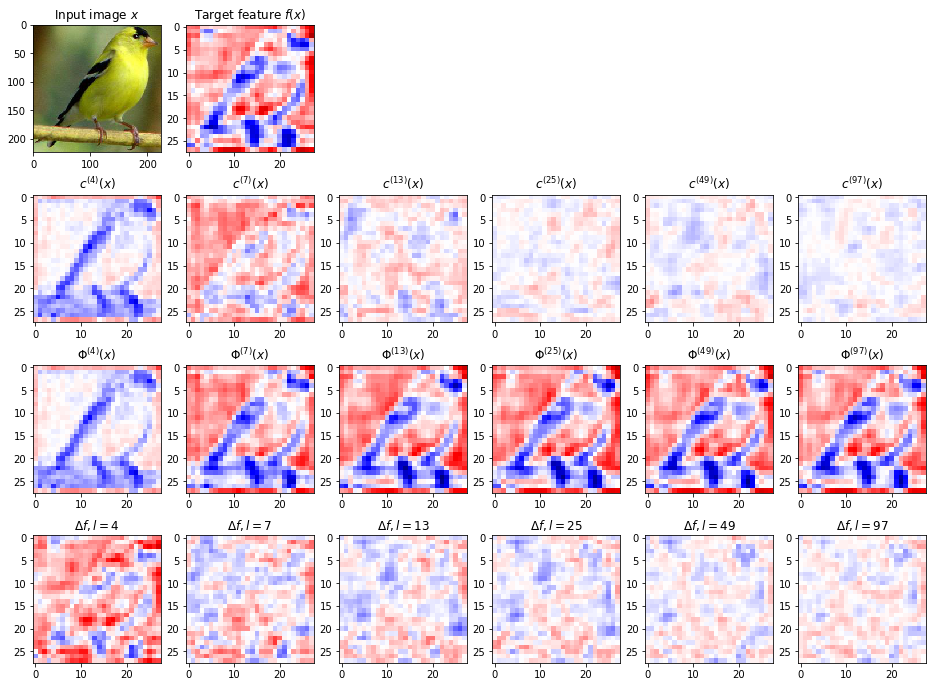

In [10]:
get_visualization(1396)

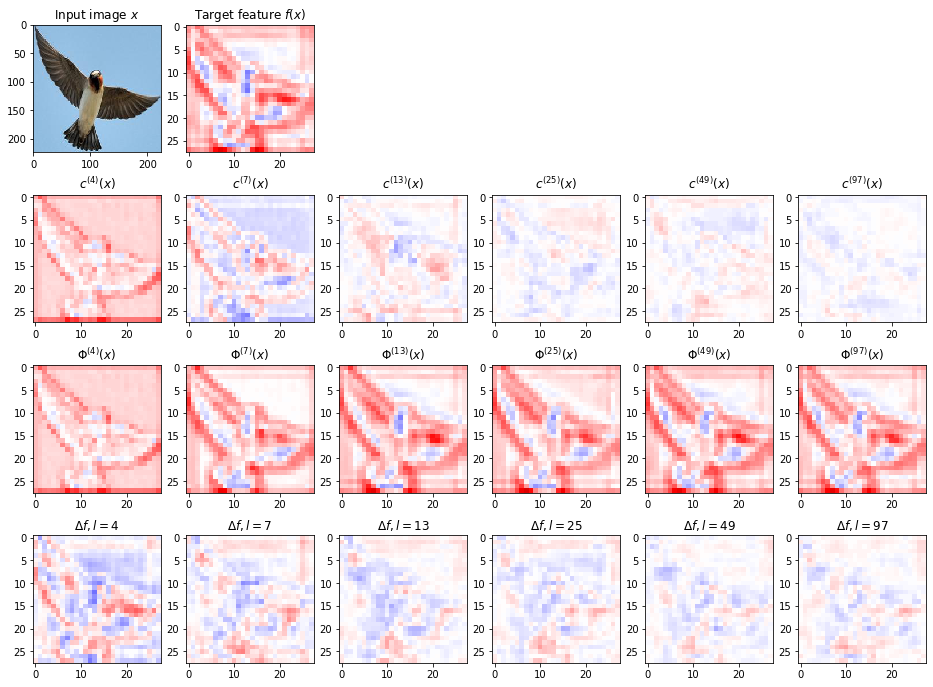

In [11]:
get_visualization(4088)

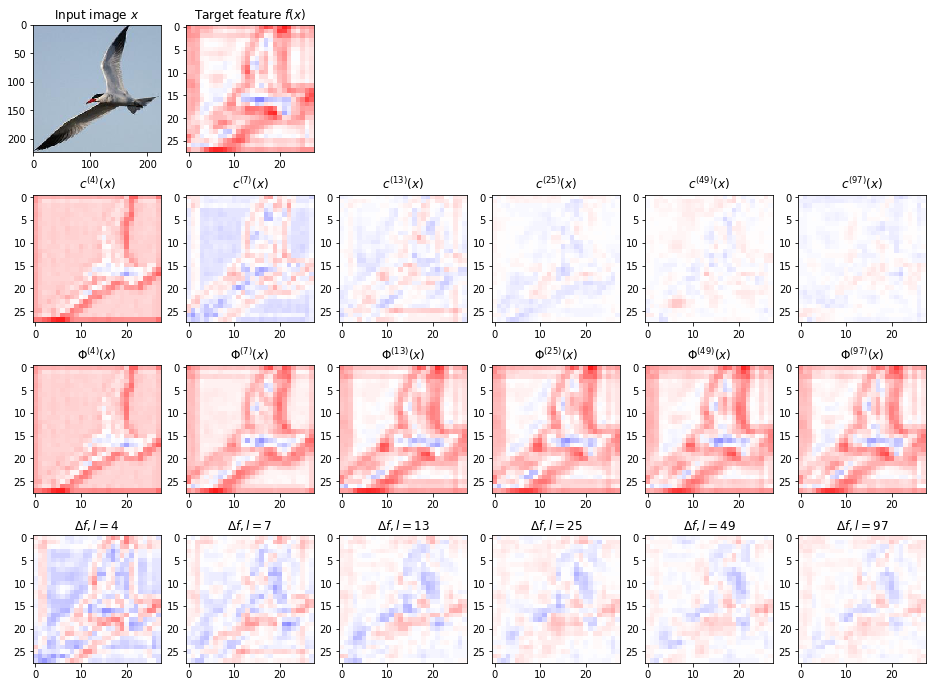

In [12]:
get_visualization(4285)

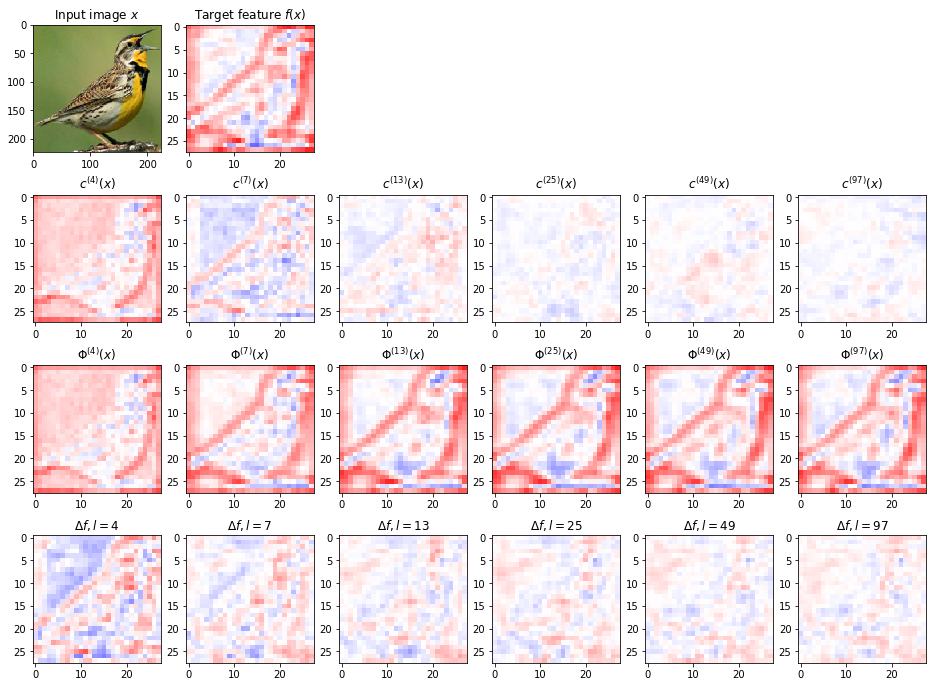

In [13]:
get_visualization(2612)